# Pylops - seismic inversion with directional derivative

### Author: M.Ravasi

In this notebook we consider the post-stack inverse problem with directional derivative in the regularization term

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt
from scipy.ndimage import gaussian_filter

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *

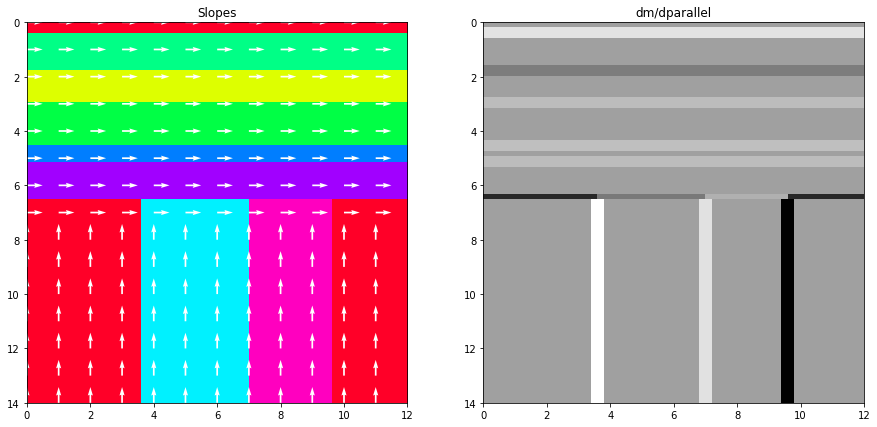

In [2]:
nx, nz = 60, 71

horlayers = np.cumsum(np.random.uniform(2, 10, 20).astype(np.int))
horlayers = horlayers[horlayers<nz//2]
nhorlayers = len(horlayers)

vertlayers = np.cumsum(np.random.uniform(2, 20, 10).astype(np.int))
vertlayers = vertlayers[vertlayers<nx]
nvertlayers = len(vertlayers)

A = 1500 * np.ones((nz, nx))
for top, base in zip(horlayers[:-1], horlayers[1:]):
    A[top:base] = np.random.normal(2000, 200)
for top, base in zip(vertlayers[:-1], vertlayers[1:]):
    A[horlayers[-1]:, top:base] = np.random.normal(2000, 200)

v = np.zeros((2, nz, nx))
v[0, :horlayers[-1]] = 1
v[1, horlayers[-1]:] = 1

Ddop = FirstDirectionalDerivative((nz, nx), v=v, sampling=(nz, nx))
dirder = Ddop * A.ravel()
dirder = dirder.reshape(nz, nx)

jump=5
fig, axs = plt.subplots(1,2,figsize=(15, 7))
im = axs[0].imshow(A, cmap='gist_rainbow', extent = (0, nx//jump, nz//jump, 0))
q = axs[0].quiver(np.flipud(v[1, ::jump, ::jump]), 
                  np.flipud(v[0, ::jump, ::jump]), color='w')
axs[0].set_title('Slopes')
axs[0].axis('tight');
axs[1].imshow(dirder, cmap='gray', extent = (0, nx//jump, nz//jump, 0))
axs[1].set_title('dm/dparallel')
axs[1].axis('tight');

Create routine for slope estimation

In [3]:
def slopeestimate(d, dz, dx, smooth=20, paralleldir=True):
    """Estimate local slopes and linearity using 
    Structure Tensor algorithm (Van Vliet and Verbeek, 1995)
    """
    gz, gx = np.gradient(d, dz, dx)
    gzz, gzx, gxx = gz*gz, gz*gx, gx*gx

    # smoothing
    gzz = gaussian_filter(gzz, sigma=smooth)
    gzx = gaussian_filter(gzx, sigma=smooth)
    gxx = gaussian_filter(gxx, sigma=smooth)

    dirs = np.zeros((2, nz, nx))
    slopes = np.zeros((nz, nx))
    linearity = np.zeros((nz, nx))
    for iz in range(nz):
        for ix in range(nx):
            T = np.array([[gzz[iz, ix], gzx[iz, ix]],
                          [gzx[iz, ix], gxx[iz, ix]]])
            E, U = np.linalg.eig(T)
            u = U[np.argmax(E)]
            v = U[np.argmin(E)]
            if paralleldir:
                dirs[:, iz, ix] = v
            else:
                dirs[:, iz, ix] = u
            slopes[iz, ix] = np.angle(v[1] + 1j*v[0])
            linearity[iz, ix] = (np.max(E) - np.min(E))/np.max(E) 
    dirs[1] *= -1
    return slopes, linearity, dirs, gz, gx, gzz, gzx, gxx

## 2D simple

Create velocity and density profiles

In [4]:
nx, nz = 300, 301
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz

layers = np.cumsum(np.random.uniform(2, 20, 50).astype(np.int))
layers =layers[layers<nz]
nlayers = len(layers)
diplayers = np.cumsum(np.random.uniform(2, 30, 35).astype(np.int))
diplayers=diplayers[diplayers<nz]

k = np.tan(np.deg2rad(45))
vp = 1500 * np.ones((nz, nx))
for top, base in zip(layers[:-1], layers[1:]):
    vp[top:base] = np.random.normal(2000, 200)
for top, base in zip(diplayers[:-1], diplayers[1:]):
    vlayer = np.random.normal(2000, 200)
    for ix in range(len(x)):
        vp[int(ix*k+top+layers[nlayers//4]):int(ix*k+base+layers[nlayers//4]), ix] = vlayer

rho = vp * 0.5 + 1000
ai = vp*rho
m = np.log(ai)

Define wavelet

In [5]:
ntwav = 41
f0 = 10
wav = ricker(np.arange(ntwav)*0.004, f0)[0]
wavc = np.argmax(wav)

In [6]:
# operator
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=False)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# data
d = (PPop*m.flatten()).reshape(nz,nx)
n = np.random.normal(0, 3e-1, d.shape)
dn = d + n

nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

d0 = (PPop*mback.flatten()).reshape(nz,nx)
dr = d - d0
dnr = dn - d0

Dot test passed, v^T(Opu)=13.307577 - u^T(Op^Tv)=13.307577


In [7]:
slopes, linearity, dirs_parallel, gz, gx, gzz, gzx, gxx = slopeestimate(d, dz, dx, smooth=20)
dirs_normal = slopeestimate(d, dz, dx, smooth=20, paralleldir=False)[2]

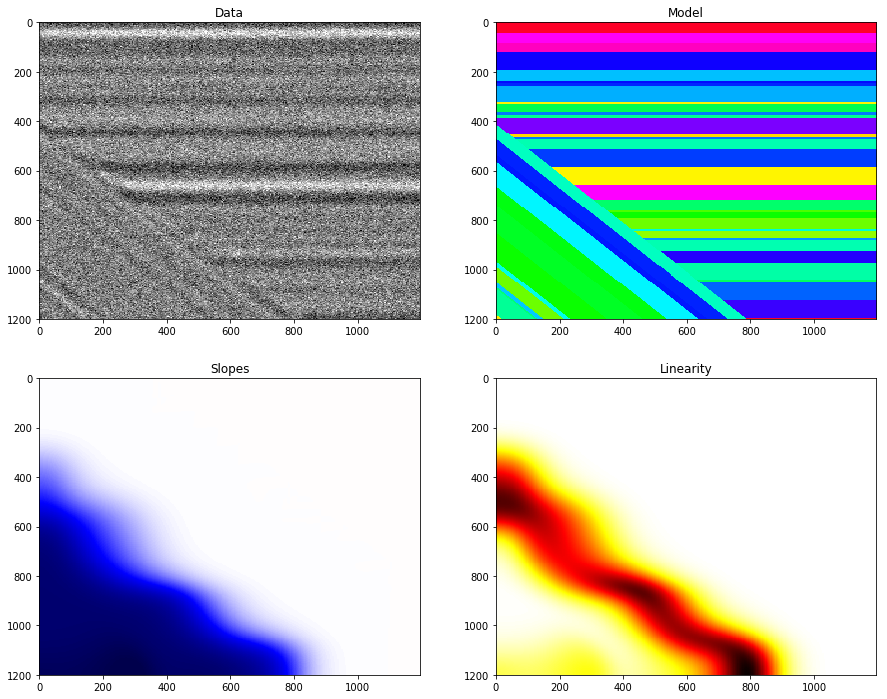

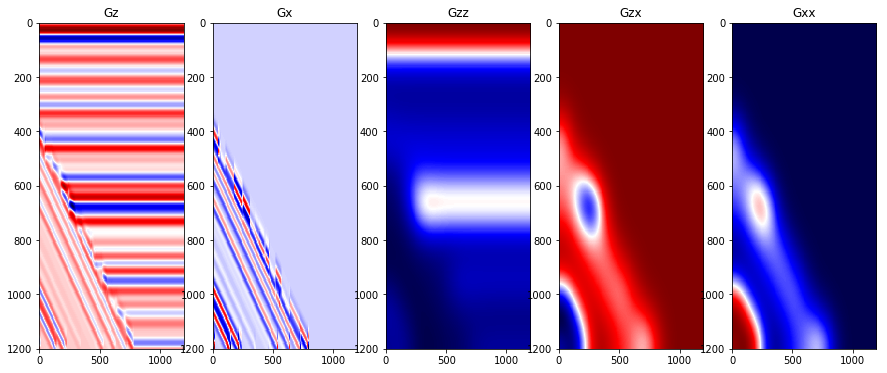

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0][0].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight');
axs[1][0].imshow(np.rad2deg(slopes), cmap='seismic', vmin=-50, vmax=50, 
                 extent = (x[0], x[-1], z[-1], z[0]))
axs[1][0].set_title('Slopes')
axs[1][0].axis('tight');

axs[1][1].imshow(linearity, cmap='hot', extent = (x[0], x[-1], z[-1], z[0]))
axs[1][1].set_title('Linearity')
axs[1][1].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
axs[0].imshow(gz, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[0].set_title('Gz')
axs[0].axis('tight')
axs[1].imshow(gx, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[1].set_title('Gx')
axs[1].axis('tight')
axs[2].imshow(gzz, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].set_title('Gzz')
axs[2].axis('tight')
axs[3].imshow(gzx, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[3].set_title('Gzx')
axs[3].axis('tight')
axs[4].imshow(gxx, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[4].set_title('Gxx')
axs[4].axis('tight');

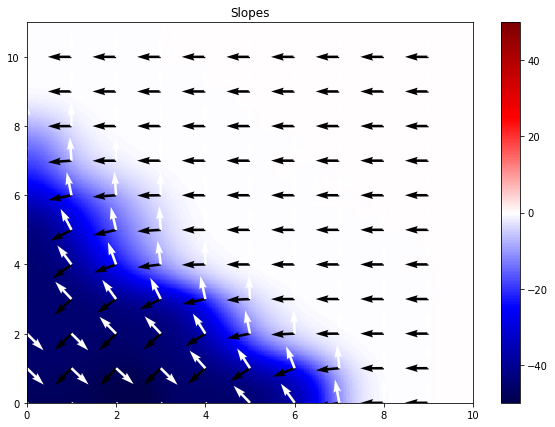

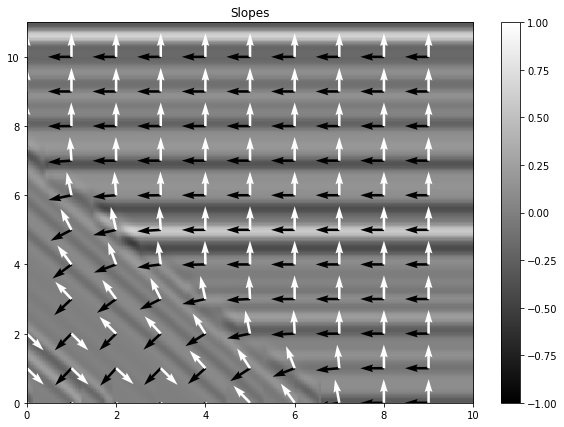

In [9]:
X, Z = np.meshgrid(x, z, indexing='ij')
jump = 30

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(np.rad2deg(slopes), cmap='seismic', vmin=-50, vmax=50, 
               extent = (0, x[::jump].size, 0, z[::jump].size))
q = ax.quiver(np.flipud(dirs_parallel[1, ::jump, ::jump]), 
              np.flipud(dirs_parallel[0, ::jump, ::jump]))
q = ax.quiver(np.flipud(dirs_normal[1, ::jump, ::jump]), 
              np.flipud(dirs_normal[0, ::jump, ::jump]), color='w')
ax.set_title('Slopes')
plt.colorbar(im, ax=ax)
ax.axis('tight');

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(d, cmap='gray',  vmin=-1, vmax=1,
               extent = (0, x[::jump].size, 0, z[::jump].size))
q = ax.quiver(np.flipud(dirs_parallel[1, ::jump, ::jump]), 
              np.flipud(dirs_parallel[0, ::jump, ::jump]))
q = ax.quiver(np.flipud(dirs_normal[1, ::jump, ::jump]), 
              np.flipud(dirs_normal[0, ::jump, ::jump]), color='w')
ax.set_title('Slopes')
plt.colorbar(im, ax=ax)
ax.axis('tight');

Compute directional derivative

In [10]:
Gop = Gradient((nz, nx), sampling=(nz, nx))
grad = Gop * m.ravel()
grad = grad.reshape(2, nz, nx)

Ddop = FirstDirectionalDerivative((nz, nx), v=dirs_parallel, sampling=(nz, nx))
dirder_parallel = Ddop * m.ravel()
dirder_parallel = dirder_parallel.reshape(nz, nx)

Ddop = FirstDirectionalDerivative((nz, nx), v=dirs_normal, sampling=(nz, nx))
dirder_normal = Ddop * m.ravel()
dirder_normal = dirder_normal.reshape(nz, nx)

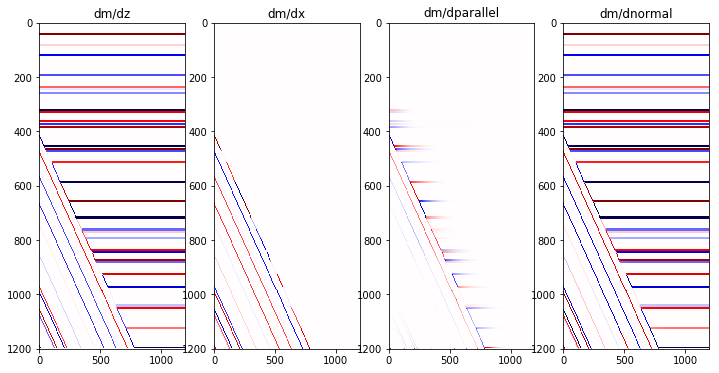

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(grad[0], cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[0].set_title('dm/dz')
axs[0].axis('tight')
axs[1].imshow(grad[1], cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[1].set_title('dm/dx')
axs[1].axis('tight')
axs[2].imshow(dirder_parallel, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[2].set_title('dm/dparallel')
axs[2].axis('tight');
axs[3].imshow(dirder_normal, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[3].set_title('dm/dnormal')
axs[3].axis('tight');

We can now implement also the second directional derivative

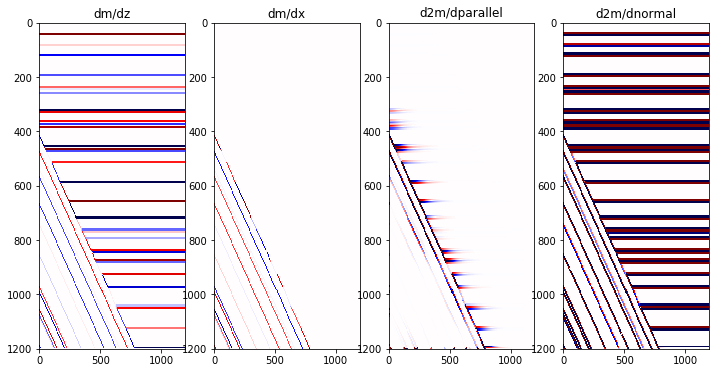

In [12]:
D2dop = SecondDirectionalDerivative((nz, nx), v=dirs_parallel, sampling=(nz, nx))
dirder_parallel2 = D2dop * m.ravel()
dirder_parallel2 = dirder_parallel2.reshape(nz, nx)

D2dop = SecondDirectionalDerivative((nz, nx), v=dirs_normal, sampling=(nz, nx))
dirder_normal2 = D2dop * m.ravel()
dirder_normal2 = dirder_normal2.reshape(nz, nx)

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(grad[0], cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[0].set_title('dm/dz')
axs[0].axis('tight')
axs[1].imshow(grad[1], cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[1].set_title('dm/dx')
axs[1].axis('tight')
axs[2].imshow(dirder_parallel2, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1e-7, vmax=1e-7)
axs[2].set_title('d2m/dparallel')
axs[2].axis('tight');
axs[3].imshow(dirder_normal2, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1e-7, vmax=1e-7)
axs[3].set_title('d2m/dnormal')
axs[3].axis('tight');

We finally perform inversion using the directional derivative as regularization term

In [13]:
#D2op  = Laplacian([nz, nx], dtype='float64')
D2op  = SecondDerivative(nz*nx, [nz, nx], dir=1, dtype='float64')
D2dop = \
    SecondDirectionalDerivative((nz, nx), v=dirs_parallel, dtype='float64') #* Diagonal(linearity.ravel())

minv_lap = NormalEquationsInversion(PPop, [D2op], dr.ravel(), epsI=1e-1,
                                    epsRs=[1e2], returninfo=False, **dict(maxiter=100))
minv_lap = mback + minv_lap.reshape(nz, nx)

minvn_lap = NormalEquationsInversion(PPop, [D2op], dnr.ravel(), epsI=5e-1,
                                    epsRs=[1e2], returninfo=False, **dict(maxiter=100))
minvn_lap = mback + minvn_lap.reshape(nz, nx)

minv_dir = NormalEquationsInversion(PPop, [D2dop], dr.ravel(), epsI=1e-1,
                                    epsRs=[1e2], returninfo=False, **dict(maxiter=100))
minv_dir = mback + minv_dir.reshape(nz, nx)

minvn_dir = NormalEquationsInversion(PPop, [D2dop], dnr.ravel(), epsI=5e-1,
                                    epsRs=[1e2], returninfo=False, **dict(maxiter=100))
minvn_dir = mback + minvn_dir.reshape(nz, nx)

In [14]:
# solve blocky
mu=.04
epsRL1s=0.1
epsRL2s=[1.]
mu_noisy=.04
epsRL1s_noisy=0.1
epsRL2s_noisy=[100.]
niter = 5
niterinner = 20

Dndop = FirstDirectionalDerivative((nz, nx), v=dirs_normal, dtype='float64') # * Diagonal(linearity.ravel()) 
Dpdop = SecondDirectionalDerivative((nz, nx), v=dirs_parallel, dtype='float64') # * Diagonal(linearity.ravel()) 
Iop = Identity(nz*nx, dtype='float64')

minv_blocky, nitern_blocky = SplitBregman(PPop, [Dndop], d.flatten(), niter, niterinner, RegsL2=[Dpdop], 
                                          mu=mu, epsRL1s=[epsRL1s], epsRL2s=epsRL2s, 
                                          x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                          **dict(iter_lim=5, damp=1e-3))
minv_blocky = minv_blocky.reshape(nz, nx)

minvn_blocky, nitern_blocky = SplitBregman(PPop, [Dndop], dn.flatten(), niter, niterinner, RegsL2=[Dpdop], 
                                           mu=mu_noisy, epsRL1s=[epsRL1s_noisy], epsRL2s=epsRL2s_noisy, 
                                           x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                           **dict(iter_lim=5, damp=1e-3))
minvn_blocky = minvn_blocky.reshape(nz, nx)

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 90300 rows and 90300 cols
niter_outer =   5     niter_inner =  20   tol = 1.00e-04
mu = 4.00e-02         epsL1 = [0.1]	  epsL2 = [1.0]     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   1.48485e+01        4.848e-01        1.397e+03
     2   1.48270e+01        7.187e-01        1.269e+03
     3   1.48134e+01        8.030e-01        1.196e+03
     4   1.48124e+01        8.948e-01        1.115e+03
     5   1.48032e+01        9.884e-01        1.068e+03

Iterations = 5        Total time (s) = 24.56
---------------------------------------------------------

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 90300 rows and 90300 cols
niter_outer =   5     niter_inner =  20   tol = 1.00e-04
mu = 4.00e-02         epsL1 = [0.1]	  epsL2 = [100.0]     
--------------

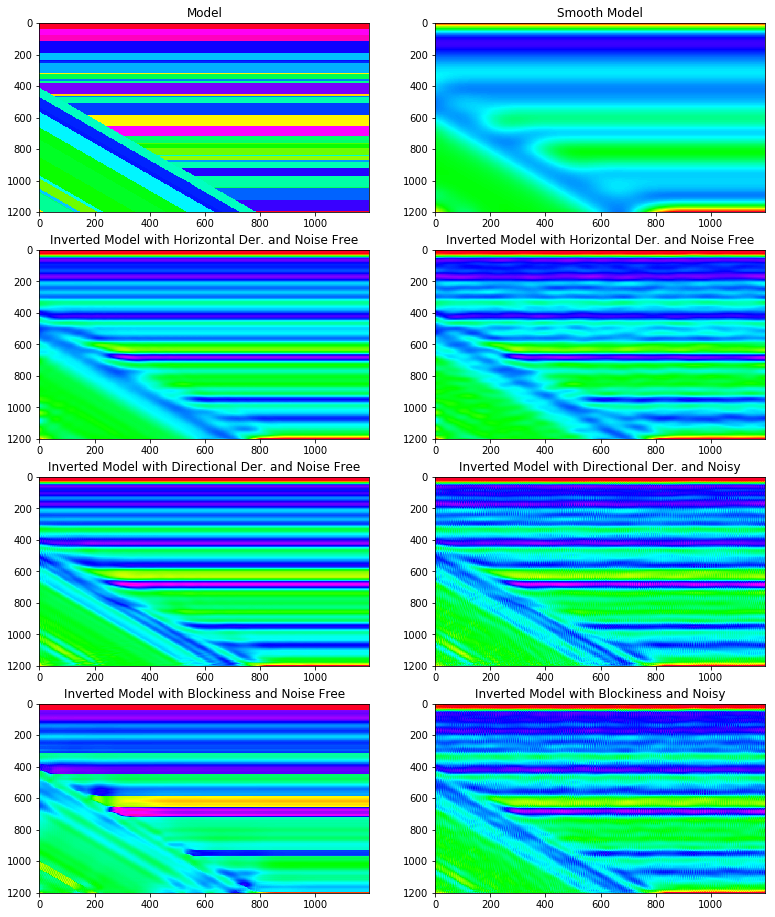

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(13, 16))
axs[0][0].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Smooth Model')
axs[0][1].axis('tight')
axs[1][0].imshow(minv_lap, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model with Horizontal Der. and Noise Free')
axs[1][0].axis('tight');
axs[1][1].imshow(minvn_lap, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model with Horizontal Der. and Noise Free')
axs[1][1].axis('tight');
axs[2][0].imshow(minv_dir, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][0].set_title('Inverted Model with Directional Der. and Noise Free')
axs[2][0].axis('tight');
axs[2][1].imshow(minvn_dir, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][1].set_title('Inverted Model with Directional Der. and Noisy')
axs[2][1].axis('tight');
axs[3][0].imshow(minv_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[3][0].set_title('Inverted Model with Blockiness and Noise Free')
axs[3][0].axis('tight');
axs[3][1].imshow(minvn_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[3][1].set_title('Inverted Model with Blockiness and Noisy')
axs[3][1].axis('tight');

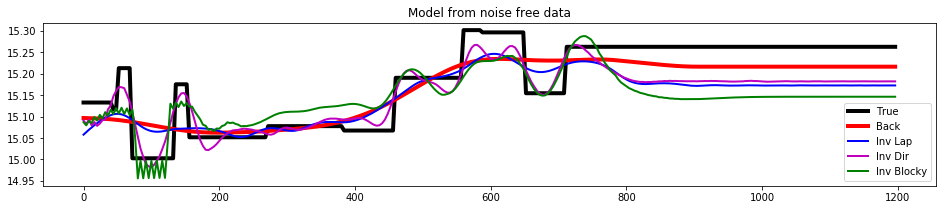

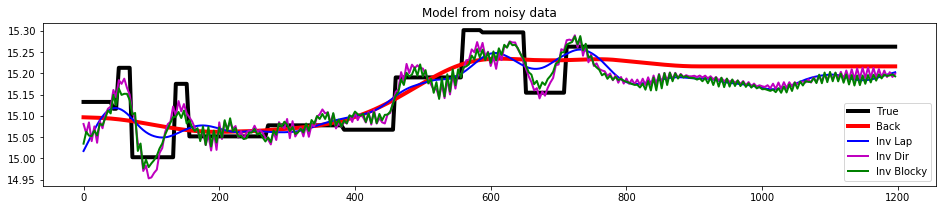

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(x, m[nz-20, :], 'k', lw=4, label='True')
ax.plot(x, mback[nz-20, :], 'r', lw=4, label='Back')
ax.plot(x, minv_lap[nz-20, :], 'b', lw=2, label='Inv Lap')
ax.plot(x, minv_dir[nz-20, :], 'm', lw=2, label='Inv Dir')
ax.plot(x, minv_blocky[nz-20, :], 'g', lw=2, label='Inv Blocky')
ax.set_title('Model from noise free data')
ax.axis('tight')
ax.legend();

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(x, m[nz-20, :], 'k', lw=4, label='True')
ax.plot(x, mback[nz-20, :], 'r', lw=4, label='Back')
ax.plot(x, minvn_lap[nz-20, :], 'b', lw=2, label='Inv Lap')
ax.plot(x, minvn_dir[nz-20, :], 'm', lw=2, label='Inv Dir')
ax.plot(x, minvn_blocky[nz-20, :], 'g', lw=2, label='Inv Blocky')
ax.set_title('Model from noisy data')
ax.axis('tight')
ax.legend();

## 2D marmousi

Import velocity model 

In [17]:
inputfile='../data/avo/marmousi.npz'

model = np.load(inputfile)
x, z, m = model['x'][::4], model['z'][::4], np.log(model['model'][::4, ::4])
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

In [18]:
# operator
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=False)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# data
d = (PPop*m.flatten()).reshape(nz,nx)
n = np.random.normal(0, 1e-1, d.shape)
dn = d + n

nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

d0 = (PPop*mback.flatten()).reshape(nz,nx)
dr = d - d0
dnr = dn - d0

Dot test passed, v^T(Opu)=-71.932067 - u^T(Op^Tv)=-71.932067


Compute slopes

In [19]:
slopes, linearity, dirs_parallel, gz, gx, gzz, gzx, gxx = slopeestimate(d, dz, dx, smooth=20, paralleldir=True)
dirs_normal = slopeestimate(d, dz, dx, smooth=20, paralleldir=False)[2]

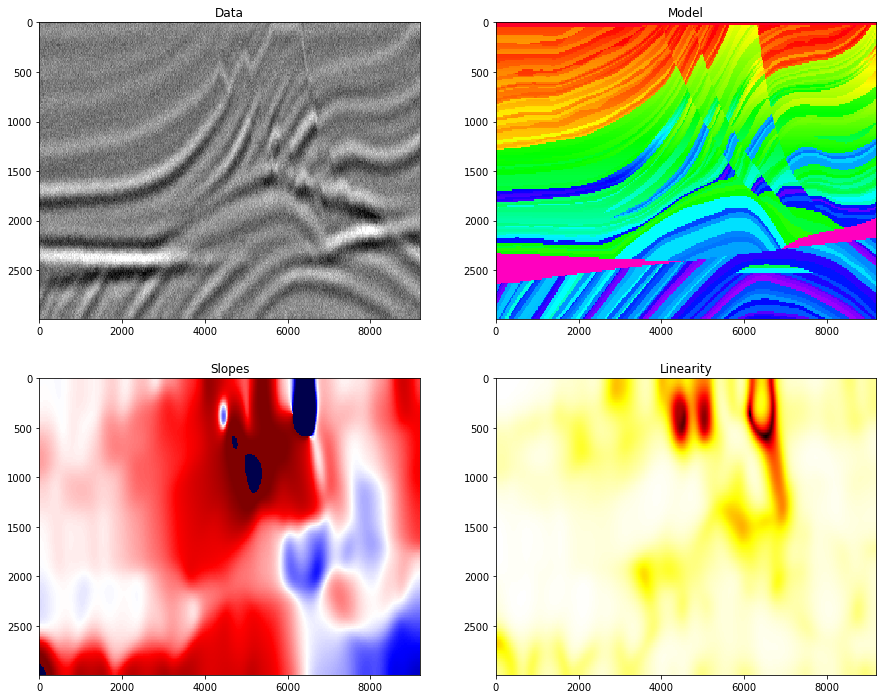

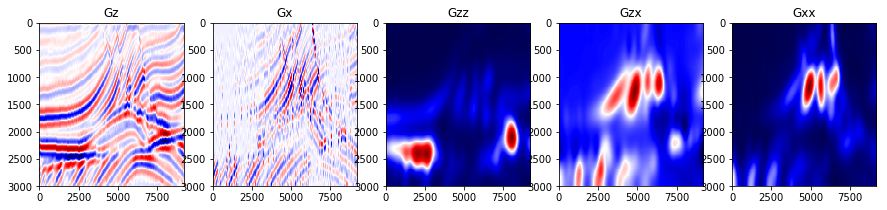

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0][0].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight');
axs[1][0].imshow(np.rad2deg(slopes), cmap='seismic', vmin=-40, vmax=40, 
                 extent = (x[0], x[-1], z[-1], z[0]))
axs[1][0].set_title('Slopes')
axs[1][0].axis('tight');

axs[1][1].imshow(linearity, cmap='hot', extent = (x[0], x[-1], z[-1], z[0]))
axs[1][1].set_title('Linearity')
axs[1][1].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(gz, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[0].set_title('Gz')
axs[0].axis('tight')
axs[1].imshow(gx, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[1].set_title('Gx')
axs[1].axis('tight')
axs[2].imshow(gzz, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].set_title('Gzz')
axs[2].axis('tight')
axs[3].imshow(gzx, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[3].set_title('Gzx')
axs[3].axis('tight')
axs[4].imshow(gxx, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]))
axs[4].set_title('Gxx')
axs[4].axis('tight');

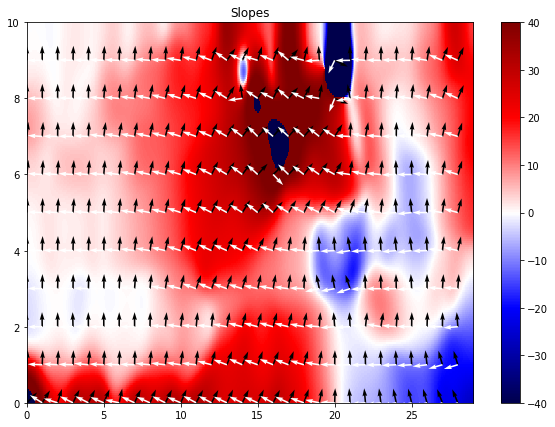

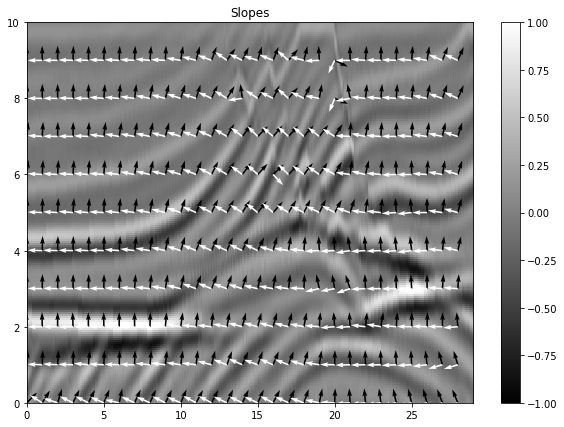

In [21]:
X, Z = np.meshgrid(x, z, indexing='ij')
jump = 20

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(np.rad2deg(slopes), cmap='seismic', vmin=-40, vmax=40, 
               extent = (0, x[::jump].size, 0, z[::jump].size))
q = ax.quiver(np.flipud(dirs_normal[1, ::jump, ::jump]), 
              np.flipud(dirs_normal[0, ::jump, ::jump]))
q = ax.quiver(np.flipud(dirs_parallel[1, ::jump, ::jump]), 
              np.flipud(dirs_parallel[0, ::jump, ::jump]), color='w')
ax.set_title('Slopes')
plt.colorbar(im, ax=ax)
ax.axis('tight');

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(d, cmap='gray',  vmin=-1, vmax=1,
               extent = (0, x[::jump].size, 0, z[::jump].size))
q = ax.quiver(np.flipud(dirs_normal[1, ::jump, ::jump]), 
              np.flipud(dirs_normal[0, ::jump, ::jump]))
q = ax.quiver(np.flipud(dirs_parallel[1, ::jump, ::jump]), 
              np.flipud(dirs_parallel[0, ::jump, ::jump]), color='w')
ax.set_title('Slopes')
plt.colorbar(im, ax=ax)
ax.axis('tight');

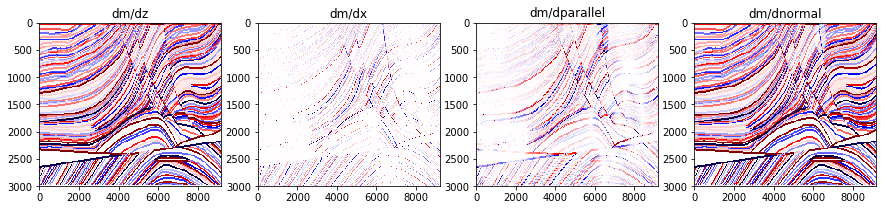

In [22]:
Gop = Gradient((nz, nx), sampling=(nz, nx))
grad = Gop * m.ravel()
grad = grad.reshape(2, nz, nx)

Ddop = FirstDirectionalDerivative((nz, nx), v=dirs_parallel, sampling=(nz, nx))
dirder_parallel = Ddop * m.ravel()
dirder_parallel = dirder_parallel.reshape(nz, nx)

Ddop = FirstDirectionalDerivative((nz, nx), v=dirs_normal, sampling=(nz, nx))
dirder_normal = Ddop * m.ravel()
dirder_normal = dirder_normal.reshape(nz, nx)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs[0].imshow(grad[0], cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[0].set_title('dm/dz')
axs[0].axis('tight')
axs[1].imshow(grad[1], cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[1].set_title('dm/dx')
axs[1].axis('tight')
axs[2].imshow(dirder_parallel, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[2].set_title('dm/dparallel')
axs[2].axis('tight');
axs[3].imshow(dirder_normal, cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]), vmin=-5e-4, vmax=5e-4)
axs[3].set_title('dm/dnormal')
axs[3].axis('tight');

In [23]:
#D2op  = Laplacian([nz, nx], dtype='float64')
D2op  = SecondDerivative(nz*nx, [nz, nx], dir=1, dtype='float64')
D2dop = SecondDirectionalDerivative((nz, nx), v=dirs_parallel, dtype='float64')

minv_lap = NormalEquationsInversion(PPop, [D2op], dr.ravel(), epsI=1e-1,
                                    epsRs=[1e1], returninfo=False, **dict(maxiter=100))
minv_lap = mback + minv_lap.reshape(nz, nx)

minvn_lap = NormalEquationsInversion(PPop, [D2op], dnr.ravel(), epsI=5e-1,
                                    epsRs=[1e1], returninfo=False, **dict(maxiter=100))
minvn_lap = mback + minvn_lap.reshape(nz, nx)

minv_dir = NormalEquationsInversion(PPop, [D2dop], dr.ravel(), epsI=1e-1,
                                    epsRs=[1e1], returninfo=False, **dict(maxiter=100))
minv_dir = mback + minv_dir.reshape(nz, nx)

minvn_dir = NormalEquationsInversion(PPop, [D2dop], dnr.ravel(), epsI=5e-1,
                                    epsRs=[1e1], returninfo=False, **dict(maxiter=100))
minvn_dir = mback + minvn_dir.reshape(nz, nx)

In [ ]:
# solve blocky
mu=.01
epsRL1s=0.01
epsRL2s=[1.]
mu_noisy=.01
epsRL1s_noisy=0.01
epsRL2s_noisy=[1.]
niter = 5
niterinner = 20

Dndop = Diagonal(linearity.ravel()) * FirstDirectionalDerivative((nz, nx), v=dirs_normal, dtype='float64')
Dpdop = Diagonal(linearity.ravel()) * SecondDirectionalDerivative((nz, nx), v=dirs_parallel, dtype='float64')
Iop = Identity(nz*nx, dtype='float64')

minv_blocky, nitern_blocky = SplitBregman(PPop, [Dndop], d.flatten(), niter, niterinner, RegsL2=[Dpdop], 
                                          mu=mu, epsRL1s=[epsRL1s], epsRL2s=epsRL2s, 
                                          x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                          **dict(iter_lim=5, damp=1e-3))
minv_blocky = minv_blocky.reshape(nz, nx)

minvn_blocky, nitern_blocky = SplitBregman(PPop, [Dndop], dn.flatten(), niter, niterinner, RegsL2=[Dpdop], 
                                           mu=mu_noisy, epsRL1s=[epsRL1s_noisy], epsRL2s=epsRL2s_noisy, 
                                           x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                           **dict(iter_lim=5, damp=1e-3))
minvn_blocky = minvn_blocky.reshape(nz, nx)

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 108288 rows and 108288 cols
niter_outer =   5     niter_inner =  20   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.01]	  epsL2 = [1.0]     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   3.46049e-01        1.714e-01        2.214e+03
     2   3.55523e-01        1.270e-01        2.164e+03
     3   3.60999e-01        1.136e-01        2.151e+03
     4   3.63650e-01        1.080e-01        2.132e+03
     5   3.65216e-01        1.050e-01        2.112e+03

Iterations = 5        Total time (s) = 36.21
---------------------------------------------------------

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 108288 rows and 108288 cols
niter_outer =   5     niter_inner =  20   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.01]	  epsL2 = [1.0]     
----------

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(13, 16))
axs[0][0].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Smooth Model')
axs[0][1].axis('tight')
axs[1][0].imshow(minv_lap, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model with Horizontal Der. and Noise Free')
axs[1][0].axis('tight');
axs[1][1].imshow(minvn_lap, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model with Horizontal Der. and Noise Free')
axs[1][1].axis('tight');
axs[2][0].imshow(minv_dir, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][0].set_title('Inverted Model with Directional Der. and Noise Free')
axs[2][0].axis('tight');
axs[2][1].imshow(minvn_dir, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][1].set_title('Inverted Model with Directional Der. and Noisy')
axs[2][1].axis('tight');
axs[3][0].imshow(minv_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[3][0].set_title('Inverted Model with Blockiness and Noise Free')
axs[3][0].axis('tight');
axs[3][1].imshow(minvn_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[3][1].set_title('Inverted Model with Blockiness and Noisy')
axs[3][1].axis('tight');

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10), sharey=True)
axs[0].plot(m[:, nx//2], z, 'k', lw=4, label='True')
axs[0].plot(mback[:, nx//2], z, 'r', lw=4, label='Back')
axs[0].plot(minv_lap[:, nx//2], z, 'b', lw=2, label='Inv Lap')
axs[0].plot(minv_dir[:, nx//2], z, 'm', lw=2, label='Inv Dir')
axs[0].plot(minv_blocky[:, nx//2], z, 'g', lw=2, label='Inv Blocky')
axs[0].set_title('Noise free data')
axs[0].legend()

axs[1].plot(m[:, nx//2], z, 'k', lw=4, label='True')
axs[1].plot(mback[:, nx//2], z, 'r', lw=4, label='Back')
axs[1].plot(minvn_lap[:, nx//2], z, 'b', lw=2, label='Inv Lap')
axs[1].plot(minvn_dir[:, nx//2], z, 'm', lw=2, label='Inv Dir')
axs[1].plot(minvn_blocky[:, nx//2], z, 'g', lw=2, label='Inv Blocky')
axs[1].set_title('Model from noisy data')
axs[1].axis('tight')
axs[1].legend()
axs[1].invert_yaxis();